# Import Libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import subprocess

import json
import csv

import pandas as pd
import numpy as np

from datetime import datetime, date, time

import snscrape.modules.twitter as sntwitter
import yfinance as yf

import re

import time

import glob

from textblob import TextBlob

# scrapeTweets() and dataWrangle() functions

In [5]:
# Keep note of directory_name -- it is based on the stock in question of the form tweets_(STOCK_NAME)
# example: tweets_GME or tweets_TSLA

def scrapeTweets(start, stop, keyword, directory, tweet_limit=1):
    if not os.path.exists(directory): # Creates directory in current directory if doesn't already exist
        os.mkdir(directory)
    
    file_path = os.path.join(directory, f'keyword:{keyword}__start:{start}_end:{stop}__limit:{tweet_limit}.csv')
    
    tweet_list = []
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{keyword} since:{start} until:{stop}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date, # Appending all tweet data into a list of list
                           tweet.id, 
                           tweet.content, 
                           tweet.user.username, 
                           tweet.user.followersCount, 
                           tweet.hashtags, 
                           tweet.cashtags, 
                           tweet.lang])
    
    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime', # Creating df of tweet data
                                                  'Tweet Id', 
                                                  'Text', 
                                                  'Username', 
                                                  'Followers Count', 
                                                  'Hashtags', 
                                                  'Cashtags', 
                                                  'Language'])
    
    df_tweets.to_csv(file_path, index=False) # Writing df_tweets into new csv file
    
    if os.path.isfile(file_path) == True:
        return print(f'Successfully saved DataFrame to {file_path}')
    else:
        return print('DataFrame not saved -- possible error has occurred.')        

In [6]:
# Creating function to clean dataframes programatically


def dataWrangle(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    return df_clean
                                               

# Creating DataFrames of GME Tweets

In [7]:
# List of file names

# Files from two directories -- scraped at different time irl 
# for the same dates within the data

file_path_tweets_GME = glob.glob('tweets_GME/*')
file_path_tweets_scraped = glob.glob('tweets_scraped/*')

In [8]:
# Creating a list of DataFrames using glob's list of files names
df_list = []
for i in file_path_tweets_GME + file_path_tweets_scraped:
    df_list.append(pd.read_csv(i))

In [9]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

def toDateTimeIndex(df): # year-month-day
    df['Datetime'] = pd.to_datetime(df['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    df.index = pd.DatetimeIndex(df['Datetime']) # Can use .set_index(<column name>) instead to make function a one liner
    df = df.drop(columns=['Datetime'])
    return df.sort_index()

In [10]:
df = dataWrangle(df_list)

In [11]:
df

,Datetime,Tweet Id,Text,Username,Followers Count
0,2021-01-08 23:18:18+00:00,1347684080905814016,$GME NEW ARTICLE : GameStop Is Caught in a Vic...,StckPro,4198
1,2021-01-08 23:17:53+00:00,1347683977327497217,@RamBhupatiraju @richard_chu97 @saxena_puru @F...,tmyrbrgh,263
2,2021-01-08 23:08:32+00:00,1347681621953159169,GameStop Is Caught in a Vicious Cycle $GME $TG...,newsfilterio,20861
3,2021-01-08 20:14:02+00:00,1347637710866030592,@michaeljburry what are your thought on what s...,JohnMOFOThomas,5
4,2021-01-08 18:56:31+00:00,1347618202612760576,"@ryancohen Can't stop, won't stop, GameStop! C...",AeternumLibera,36
...,...,...,...,...,...
106623,2021-02-05 14:57:54+00:00,1357705012919508995,"@carlquintanilla @CNBC They Stopped Us Again, ...",BleezyforSheezy,131
106624,2021-02-05 14:57:54+00:00,1357705010222673923,$GME said,prodigenoir,848
106625,2021-02-05 14:57:53+00:00,1357705006724620290,$GME and $AMC halted 🤨,tweek3634,24
106626,2021-02-05 14:57:52+00:00,1357705004996517891,BUY #AMC and #GME 💎🙌🚀🦍🍌 (not financial advice),YoSheenn,201


In [12]:
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.floor('d').dt.tz_localize(tz=None)

# Polarity Scores

A list of goals to accomplish: \
    - Figure out polarity/subjectivity scores for every tweet\
    - For now we want to work with dates from 01/21/2021 and onwards as a test\
    - Mess about with distribution of negative/positive/neutral scores to have a healthy balance of samples\
    - Break everything up by days\
    - Move onto bringing in financial data

In [13]:
# Creating column of scores

df['Polarity/Subjectivity Scores'] = df['Text'].apply(lambda text: TextBlob(text).sentiment)

In [14]:
# Cleaning out scores of (0,0)

df_pol_clean = df[df['Polarity/Subjectivity Scores'] != (0.0,0.0)].set_index('Datetime').sort_index()

In [15]:
# Filtering out dates with low tweet volume

df_sorted_dates = df_pol_clean["2021-01-21":]

In [16]:
df_sorted_dates

,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores
Datetime,,,,,
2021-01-21,1352342019788607489,"So, Dr. Burry, some free advice for a good guy...",PBRStreetGang7,896,"(0.15555555555555559, 0.6611111111111111)"
2021-01-21,1352343155224416257,"@LizClaman @GameStop @ClamanCountdown Liz, And...",HiBeam65,73,"(-0.18787878787878784, 0.4055555555555555)"
2021-01-21,1352345333469077508,@FarisBakkar @Long_GME E-commerce growth for G...,MarcosMalakos,340,"(0.05833333333333335, 0.4583333333333333)"
2021-01-21,1352345709983404032,@FarisBakkar @Long_GME You are honestly recycl...,MarcosMalakos,340,"(0.049999999999999975, 0.5083333333333333)"
2021-01-21,1352346412080627723,UPDATE: Citron's Andrew Left On GameStop Short...,FuzzyLogicBrock,580,"(0.075, 0.3989583333333333)"
...,...,...,...,...,...
2021-02-11,1359695651165077504,@KChampbell @2009Michael1984 Just think if Blo...,kul_kan2017,99,"(0.05393939393939393, 0.4242424242424243)"
2021-02-11,1359695846695141377,"@aurban22 @RocketCatchnBob Yes, you should be ...",j2_trade,65,"(0.45, 0.7866666666666667)"
2021-02-11,1359695921135538177,"My retarded question is, since diamond hands a...",NPizzi,541,"(-0.2, 0.45)"


In [17]:
# This may cause imbalances.
# Consider first figuring out polarity scores PER DAY

def polarityCategories(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [18]:
# Creating new column with polarity categories: Positive, Neutral, Negative

df_sorted_dates['Polarity Categories'] = df_sorted_dates['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))

C:\Users\Daanish\AppData\Local\Temp/ipykernel_12228/901341670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sorted_dates['Polarity Categories'] = df_sorted_dates['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))


In [19]:
# Seemingly balanced values

df_sorted_dates.value_counts('Polarity Categories')

Polarity Categories
Positive    40299
Negative    17899
Neutral     15792
dtype: int64

In [20]:
df_sorted_dates

,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores,Polarity Categories
Datetime,,,,,,
2021-01-21,1352342019788607489,"So, Dr. Burry, some free advice for a good guy...",PBRStreetGang7,896,"(0.15555555555555559, 0.6611111111111111)",Positive
2021-01-21,1352343155224416257,"@LizClaman @GameStop @ClamanCountdown Liz, And...",HiBeam65,73,"(-0.18787878787878784, 0.4055555555555555)",Negative
2021-01-21,1352345333469077508,@FarisBakkar @Long_GME E-commerce growth for G...,MarcosMalakos,340,"(0.05833333333333335, 0.4583333333333333)",Positive
2021-01-21,1352345709983404032,@FarisBakkar @Long_GME You are honestly recycl...,MarcosMalakos,340,"(0.049999999999999975, 0.5083333333333333)",Neutral
2021-01-21,1352346412080627723,UPDATE: Citron's Andrew Left On GameStop Short...,FuzzyLogicBrock,580,"(0.075, 0.3989583333333333)",Positive
...,...,...,...,...,...,...
2021-02-11,1359695651165077504,@KChampbell @2009Michael1984 Just think if Blo...,kul_kan2017,99,"(0.05393939393939393, 0.4242424242424243)",Positive
2021-02-11,1359695846695141377,"@aurban22 @RocketCatchnBob Yes, you should be ...",j2_trade,65,"(0.45, 0.7866666666666667)",Positive
2021-02-11,1359695921135538177,"My retarded question is, since diamond hands a...",NPizzi,541,"(-0.2, 0.45)",Negative


# Categorizing polarity scores per day (Keeping this on the side for now)

Our goal here is to quantify one polarity score per day. We do this individually per day based on the distribution of the scores; if the distribution is skewed, we use the median, if it isn't we use mean.

In [21]:
# We will use this section to approach this problem at a different angle.

<AxesSubplot:ylabel='Frequency'>

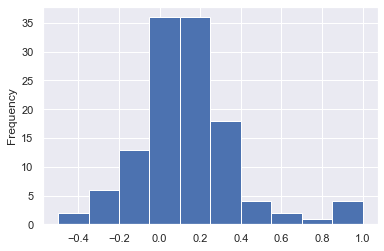

In [22]:
df_sorted_dates.loc['2021-01-21']['Polarity/Subjectivity Scores'].apply(lambda x: x[0]).plot.hist(bins = 10)

In [23]:
df_sorted_dates['Polarity/Subjectivity Scores'].apply(lambda x:x[0]).groupby('Datetime').median()

Datetime
2021-01-21    0.100000
2021-01-22    0.068725
2021-01-23    0.083333
2021-01-24    0.087500
2021-01-25    0.095238
2021-01-26    0.050000
2021-01-27    0.100000
2021-01-28    0.066667
2021-01-29    0.062500
2021-01-30    0.033333
2021-01-31    0.085417
2021-02-01    0.057143
2021-02-02    0.095833
2021-02-03    0.100000
2021-02-04    0.033333
2021-02-05    0.092083
2021-02-06    0.100000
2021-02-07    0.137500
2021-02-08    0.116667
2021-02-09    0.100000
2021-02-10    0.100000
2021-02-11    0.100000
Name: Polarity/Subjectivity Scores, dtype: float64

In [24]:
# Polarity Categories count per day

print(pd.DataFrame(df_sorted_dates['Polarity Categories'].groupby('Datetime').value_counts()).to_string())

                                Polarity Categories
Datetime   Polarity Categories                     
2021-01-21 Positive                              81
           Negative                              21
           Neutral                               20
2021-01-22 Positive                             278
           Negative                             137
           Neutral                              115
2021-01-23 Positive                             103
           Negative                              48
           Neutral                               39
2021-01-24 Positive                              80
           Negative                              37
           Neutral                               28
2021-01-25 Positive                             631
           Negative                             292
           Neutral                              222
2021-01-26 Positive                             949
           Negative                             502
           N

## GME Stock Data

In [25]:
# Get the data for $GME by specifying the stock ticker, start date, and end date
data_stock_gme = yf.download('GME','2021-01-21','2021-02-12')
data_stock_gme.index = data_stock_gme.index.tz_localize(tz=None)

[*********************100%***********************]  1 of 1 completed


In [26]:
data_stock_gme

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-21,39.230000,44.750000,37.000000,43.029999,43.029999,56216900
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900
2021-01-25,96.730003,159.179993,61.130001,76.790001,76.790001,177874000
2021-01-26,88.559998,150.000000,80.199997,147.979996,147.979996,178588000
2021-01-27,354.829987,380.000000,249.000000,347.510010,347.510010,93396700
2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800
2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50566100
2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200
2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100


In [27]:
data_stock_gme['Closing Differences'] = data_stock_gme['Adj Close'].diff()
data_stock_gme['C-O/O'] = ((data_stock_gme['Close']-data_stock_gme['Open'])/data_stock_gme['Open'])*100

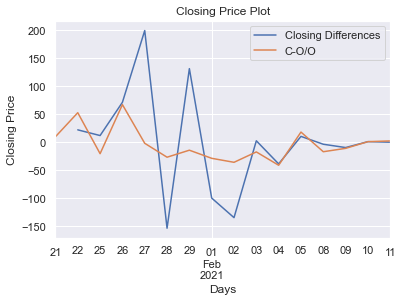

In [28]:
# Plot

data_stock_gme[['Closing Differences', 'C-O/O']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

In [29]:
data_stock_gme.index = data_stock_gme.index.rename(name='Datetime')

In [30]:
# Why is there NaN values for Volume and closing differences?
# Because the stock market is only opened on business days!
# So we dropped NaN values

df_merged = data_stock_gme.merge(df_sorted_dates, how='right', left_index=True, right_index=True).dropna()

In [31]:
df_merged['Closing Trend'] = df_merged['Closing Differences'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")

In [32]:
df_merged

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,C-O/O,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores,Polarity Categories,Closing Trend
Datetime,,,,,,,,,,,,,,,
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900.0,21.980003,52.641470,1352694733626372096,GameStop soars after 'Big Short' investor Mich...,Tonyrose5583,348,"(0.0, 0.16666666666666666)",Neutral,Positive_Trend
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900.0,21.980003,52.641470,1352694823170539521,The #StockMarket is efficient. #GameStop stock...,AmericanPWealth,885,"(0.4166666666666667, 0.48333333333333334)",Positive,Positive_Trend
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900.0,21.980003,52.641470,1352695836837367812,RIP to the psychos who were buying game stop a...,Tylerm0101,314,"(-0.4, 0.4)",Negative,Positive_Trend
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900.0,21.980003,52.641470,1352695923172900866,#gamestop stock skyrockets to the moon 🚀🌝 as s...,ghostsquawk,630,"(0.2, 0.55)",Positive,Positive_Trend
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900.0,21.980003,52.641470,1352696539404263427,@ParikPatelCFA $GME partnered with $TSLA to bu...,financeoholic,439,"(0.25, 0.3333333333333333)",Positive,Positive_Trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,50.009998,55.320000,48.220001,51.099998,51.099998,13056700.0,-0.100002,2.179564,1359695651165077504,@KChampbell @2009Michael1984 Just think if Blo...,kul_kan2017,99,"(0.05393939393939393, 0.4242424242424243)",Positive,Negative_Trend
2021-02-11,50.009998,55.320000,48.220001,51.099998,51.099998,13056700.0,-0.100002,2.179564,1359695846695141377,"@aurban22 @RocketCatchnBob Yes, you should be ...",j2_trade,65,"(0.45, 0.7866666666666667)",Positive,Negative_Trend
2021-02-11,50.009998,55.320000,48.220001,51.099998,51.099998,13056700.0,-0.100002,2.179564,1359695921135538177,"My retarded question is, since diamond hands a...",NPizzi,541,"(-0.2, 0.45)",Negative,Negative_Trend


# Dealing with Imbalances

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
from collections import Counter

In [35]:
sampler = SMOTE(random_state=42)

# Modeling

### Imports and Train/Test Split

In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score
from sklearn import metrics

In [37]:
X = df_merged
y = df_merged['Closing Trend']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Support Vector Machine (Baseline)

In [39]:
transformer_svm = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [42]:
pipe_svm = Pipeline([
    ('ohe', transformer_svm),
    ('svm', svm.LinearSVC())
])

In [44]:
pipe_svm_fit = pipe_svm.fit(X_train, y_train)

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [45]:
pipe_svm_fit.score(X_test, y_test)

0.5198527057316683

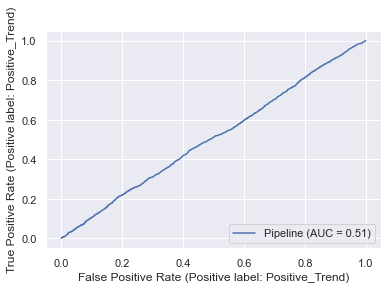

In [46]:
RocCurveDisplay.from_estimator(pipe_svm_fit, X_test, y_test)

#### Random Forest Classifier (Baseline)

In [48]:
transformer_rfc = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [49]:
pipe_rfc = Pipeline([
    ('ohe', transformer_rfc),
    ('randomforest', RandomForestClassifier())
])

In [50]:
pipe_rfc_fit = pipe_rfc.fit(X_train, y_train)

In [51]:
pipe_rfc_fit.score(X_test, y_test)

0.584694204290746

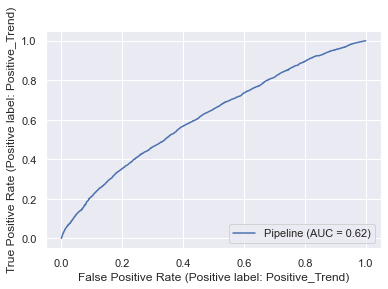

In [52]:
display_ROC_rfc = RocCurveDisplay.from_estimator(pipe_rfc, X_test, y_test)
plt.show();

In [62]:
y_pred = pipe_rfc_fit.predict(X_test)

In [63]:
f1_score(y_true=y_test, y_pred=y_pred, pos_label= "Positive_Trend")

0.5485555168813087

#### Logistic Regression (Baseline)

In [65]:
transformer_logit = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [66]:
pipe_logit = Pipeline([
    ('ohe', transformer_logit),
    ('logit', LogisticRegression())
])

In [68]:
# Good evaluation for random forest and logistic 

def model_evaluation(model, X, y_true, positive_label):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, pos_label=positive_label), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, pos_label=positive_label), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs, pos_label=positive_label)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    scores['f1 score'] = round(f1_score(y_true=y_true, y_pred=y_pred, pos_label= "Positive_Trend"), 4)
    return scores

def print_model_evaluation(model_name, scores):
    print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))

In [69]:
model_evaluation(pipe_logit, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.5199,
 'precision': 0.5422,
 'recall': 0.0075,
 'area under precision-recall curve': 0.4891,
 'f1 score': 0.0148}

In [70]:
.

SyntaxError: invalid syntax (Temp/ipykernel_12228/1933637684.py, line 1)